# Load existing tables of airbnb/booking and scraped data

In [0]:
# ============================================================
# CONFIG: Azure Storage Account and Container Names
# Purpose:
#   Define reusable identifiers for the Azure storage account
#   and blob container used throughout the notebook.
# ============================================================

storage_account = "lab94290"  
container = "airbnb"

In [0]:
# ============================================================
# CONFIG + UTILS: Table Names, Input Paths, and Existence Checks
# Purpose:
#   - Define all input/output tables and CSV paths used in the pipeline
#   - Provide a robust utility to check whether Spark tables exist
#   - Declare expected platforms/sources for later auditing and validation
# ============================================================

BASE_TABLE = "default.gold_rome_listings_with_llm"      
OUTPUT_TABLE = "default.gold_rome_listings_with_ai"     # merged output table
HOSTEL_CSV_PATH = "dbfs:/FileStore/tables/final_hostel_results_filtered.csv"  # Scraped HostelWorld dataset
HOSTEL2_CSV_PATH = "dbfs:/FileStore/tables/hostelworld2.csv"  # NEW Scraped HostelWorld dataset
PROD = True # Flag to indicate production or development mode, if prod is True LLM call will not run

from pyspark.sql import functions as F

def table_exists(full_name: str) -> bool:
    """Return True if a Spark table exists (supports catalog.schema.table or schema.table)."""
    try:
        return spark.catalog.tableExists(full_name)
    except Exception:
        # Fallback for some runtimes
        try:
            if "." in full_name:
                parts = full_name.split(".")
                if len(parts) == 2:
                    db, tbl = parts
                    return spark._jsparkSession.catalog().tableExists(db, tbl)
                if len(parts) == 3:
                    catalog, db, tbl = parts
                    # Many workspaces don't expose catalog in tableExists; try db.tbl
                    return spark._jsparkSession.catalog().tableExists(db, tbl)
            return False
        except Exception:
            return False

print("BASE_TABLE exists:", table_exists(BASE_TABLE))
print("OUTPUT_TABLE exists:", table_exists(OUTPUT_TABLE))
expedia_CSV_PATH = "dbfs:/FileStore/tables/expedia.csv"  # Expedia dataset

# Always show these platforms in audit tables (0 still shown)
EXPECTED_PLATFORMS = ["airbnb", "booking", "hostelworld", "expedia"]
# Always show these *source datasets* in audit tables (0 still shown)
EXPECTED_SOURCES = ["base", "hostelworld_1", "hostelworld_2", "expedia"]


BASE_TABLE exists: True
OUTPUT_TABLE exists: True


In [0]:
# ============================================================
# AUDIT UTILITIES: Platform and Source Coverage Validation
# Purpose:
#   - Provide reusable helpers to audit dataset composition
#   - Ensure all expected platforms and sources appear,
#     even when their record count is zero
# ============================================================

from pyspark.sql import functions as F

def _make_list_df(colname: str, values):
    return spark.createDataFrame([(v,) for v in values], [colname])

def show_platform_table(df, label: str, expected=EXPECTED_PLATFORMS):
    """Shows counts by platform, including expected platforms even if count=0."""
    base = _make_list_df("platform", expected)
    counts = df.groupBy("platform").count()
    out = base.join(counts, on="platform", how="left").fillna({"count": 0}).orderBy("platform")
    print(f"\n=== {label} (platform counts) ===")
    out.show(200, truncate=False)
    return out

def show_source_table(df, label: str, expected=EXPECTED_SOURCES):
    """Shows counts by source_name, including expected sources even if count=0."""
    if "source_name" not in df.columns:
        print(f"\n=== {label} (source counts) ===")
        print("No 'source_name' column in this DF.")
        return None
    base = _make_list_df("source_name", expected)
    counts = df.groupBy("source_name").count()
    out = base.join(counts, on="source_name", how="left").fillna({"count": 0}).orderBy("source_name")
    print(f"\n=== {label} (source counts) ===")
    out.show(200, truncate=False)
    return out


In [0]:
# ============================================================
# AUTH + INGEST UTILS: Switch SAS and Load Airbnb / Booking Data
# Purpose:
#   - Switch SAS token based on dataset (Airbnb vs Booking)
#   - Load the corresponding Parquet dataset safely
# ============================================================

storage_account = "lab94290"

AIRBNB_CONTAINER = "airbnb"
BOOKING_CONTAINER = "booking"

AIRBNB_PATH = f"abfss://{AIRBNB_CONTAINER}@{storage_account}.dfs.core.windows.net/airbnb_1_12_parquet"
BOOKING_PATH = f"abfss://{BOOKING_CONTAINER}@{storage_account}.dfs.core.windows.net/booking_1_9.parquet"

booking_sas_token = "sp=rle&st=2025-12-24T17:40:17Z&se=2026-03-28T00:55:17Z&spr=https&sv=2024-11-04&sr=c&sig=MDPp34fAOi%2B4oUejQ8HnQ4PblcvEe8dCpwzLQgBCsPk%3D"
airbnb_sas_token  = "sp=rle&st=2025-12-24T17:37:04Z&se=2026-02-28T01:52:04Z&spr=https&sv=2024-11-04&sr=c&sig=a0lx%2BS6PuS%2FvJ9Tbt4NKdCJHLE9d1Y1D6vpE1WKFQtk%3D"


def set_sas(acct: str, sas_token: str):
    sas_token = sas_token.lstrip("?").strip()
    spark.conf.set(f"fs.azure.account.auth.type.{acct}.dfs.core.windows.net", "SAS")
    spark.conf.set(
        f"fs.azure.sas.token.provider.type.{acct}.dfs.core.windows.net",
        "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider"
    )
    spark.conf.set(f"fs.azure.sas.fixed.token.{acct}.dfs.core.windows.net", sas_token)


def load_airbnb():
    set_sas(storage_account, airbnb_sas_token)
    print("SAS active: airbnb")
    return spark.read.parquet(AIRBNB_PATH)


def load_booking():
    set_sas(storage_account, booking_sas_token)
    print("SAS active: booking")
    return spark.read.parquet(BOOKING_PATH)

booking = load_booking()
airbnb = load_airbnb()



SAS active: booking
SAS active: airbnb


# Create base tables for all sources before merging

In [0]:
# ============================================================
# TRANSFORM: Normalize Airbnb Data and Filter to Rome Listings FOR AIRBNB
# Purpose:
#   - Build a standardized Airbnb schema (id, platform, text-for-LLM, rating, etc.)
#   - Filter to Rome/Roma, Italy-only, exclude Romania
#   - Deduplicate and sanity-check the result
# ============================================================



# Create airbnb base table
airbnb_base = (
    airbnb
    .withColumn(
        "listing_id",
        F.coalesce(F.col("property_id").cast("string"), F.sha2(F.col("final_url").cast("string"), 256))
    )
    .withColumn("platform", F.lit("airbnb"))
    .withColumn(
        "review_text_for_ai",
        F.concat_ws(
            "\n\n",
            F.col("reviews").cast("string"),
            F.col("description").cast("string"),
            F.col("highlights").cast("string"),
            F.col("house_rules").cast("string")
        )
    )
    # Treat 0 / negative / missing ratings as NULL (not a real rating)
    .withColumn(
        "rating",
        F.when(F.col("ratings").cast("double").isNull(), F.lit(None).cast("double"))
         .when(F.col("ratings").cast("double") <= 0.0, F.lit(None).cast("double"))
         .otherwise(F.col("ratings").cast("double"))
    )
    # Keep review_count numeric; allow NULL if missing
    .withColumn("review_count", F.col("property_number_of_reviews").cast("int"))
    .withColumn(
        "title_norm",
        F.coalesce(
            F.col("listing_title").cast("string"),
            F.col("listing_name").cast("string"),
            F.col("name").cast("string")
        )
    )
    .withColumn("city_norm", F.lower(F.col("location").cast("string")))
    .withColumn("country_norm", F.lower(F.col("country").cast("string")))
    .withColumn("url", F.coalesce(F.col("final_url").cast("string"), F.col("url").cast("string")))
    .withColumn("lat_norm", F.col("lat").cast("double"))
    .withColumn("lng_norm", F.col("long").cast("double"))
)

# Filter the table to contain only rome data
airbnb_rome = (
    airbnb_base
    .withColumn("city_norm", F.lower(F.col("location").cast("string")))
    .filter(
        # Must be Italy in the same string
        (F.col("city_norm").contains("italy") | F.col("city_norm").contains("italia"))
        &
        # Must contain Rome or Roma (as word)
        (
            F.col("city_norm").rlike(r"(^|[^a-z])rome([^a-z]|$)") |
            F.col("city_norm").rlike(r"(^|[^a-z])roma([^a-z]|$)")
        )
        &
        # Explicitly exclude Romania
        (~F.col("city_norm").contains("romania"))
    )
    .dropDuplicates(["listing_id"])
    .dropna(subset=["listing_id", "title_norm"])
)

# Sanity: show 20 and confirm all have rome/roma
airbnb_rome.select("listing_id","title_norm","rating","review_count","city_norm").show(20, truncate=120)
print("airbnb_rome count:", airbnb_rome.count())



airbnb_rome.select("listing_id", "title_norm", "rating", "review_count", "city_norm").show(5, truncate=120)


+-------------------+---------------------------------------------------+------+------------+------------------+
|         listing_id|                                         title_norm|rating|review_count|         city_norm|
+-------------------+---------------------------------------------------+------+------------+------------------+
|1000448625268643281|              Domus Vatican Holiday Suite Familiare|   5.0|           5|rome, lazio, italy|
|1000590114262830556|                               Trastevere Apartment|  4.68|          19|rome, lazio, italy|
|1000665318988962604|                                   the Pope's house|  NULL|        NULL|rome, lazio, italy|
|1000773211046164351|                      Casa Abeba, the Tower of Rome|  4.33|           6|rome, lazio, italy|
|1001236256998280519|                    Beds!Termini-Room in GuestHouse|   4.8|          71|rome, lazio, italy|
|1002049145788661788|                                White Miracle Suite|  4.93|          60|rom

In [0]:
# ============================================================
# TRANSFORM: Normalize Booking.com Data and Filter Rome Listings (FOR BOOKING)
# Purpose:
#   - Build a standardized Booking.com base table aligned with
#     the Airbnb schema (IDs, platform, text-for-LLM, ratings)
#   - Filter the dataset to Rome-only listings
#   - Deduplicate and validate core identifying fields
# ============================================================

load_booking()

# Create booking base table
booking_base = (
    booking
    .withColumn("listing_id", F.col("hotel_id").cast("string"))
    .withColumn("platform", F.lit("booking"))
    .withColumn(
        "review_text_for_ai",
        F.concat_ws("\n\n",
            F.col("top_reviews").cast("string"),
            F.col("description").cast("string"),
            F.col("property_highlights").cast("string"),
            F.col("fine_print").cast("string"),
            F.col("house_rules").cast("string")
        )
    )
    .withColumn("rating", F.col("review_score").cast("double"))
    .withColumn("review_count", F.col("number_of_reviews").cast("int"))
    .withColumn("title_norm", F.col("title").cast("string"))
    .withColumn("city_norm", F.lower(F.col("city").cast("string")))
    .withColumn("country_norm", F.lower(F.col("country").cast("string")))
)
# Filter table to contain only Rome data
booking_rome = (booking_base
    .filter(F.col("city_norm")==("rome"))
    .dropDuplicates(["listing_id"])
    .dropna(subset=["listing_id", "title_norm"])
)

booking_rome.select("listing_id","title_norm","rating","review_count","city_norm").show(5, truncate=120)


SAS active: booking
+----------+----------------------------------------------------------------------+------+------------+---------+
|listing_id|                                                            title_norm|rating|review_count|city_norm|
+----------+----------------------------------------------------------------------+------+------------+---------+
|   1001400|                                                       Minerva's Place|   8.5|         135|     rome|
|  10015321|Stylish Apartment Rome Air Conditionig WiFi TV 50 metro 4 minutes away|   9.2|          84|     rome|
|  10016153|                                                   DaMari in Don Bosco|   8.5|         101|     rome|
|  10022574|                                                         Ovidio Luxury|   8.1|          79|     rome|
|  10025967| "La Piccola Londra "appartamento a Roma 5 minuti da piazza del Popolo|   9.1|          65|     rome|
+----------+--------------------------------------------------------

In [0]:
# ============================================================
# CACHE + QA: Materialize Airbnb/Booking Rome Data Under Correct SAS
# Purpose:
#   - Clear Spark cache to avoid stale/incorrect reads after SAS switching
#   - Materialize (cache + count) each platform's Rome dataset under the
#     correct SAS token to prevent later 403 errors from lazy reads
#   - Compute quick per-platform summary stats for validation
# ============================================================


# Reset cached state
spark.catalog.clearCache()

# 1) Materialize Airbnb side under AIRBNB token (forces file reads now with correct SAS)
load_airbnb()
airbnb_rome_cached = airbnb_rome.cache()
_ = airbnb_rome_cached.count()

# 2) Materialize Booking side under BOOKING token (forces file reads now with correct SAS)
load_booking()
booking_rome_cached = booking_rome.cache()
_ = booking_rome_cached.count()

# 3) Quick sanity stats
airbnb_stats = airbnb_rome_cached.agg(
    F.countDistinct("listing_id").alias("num_listings"),
    F.sum("review_count").alias("total_reviews"),
    F.avg("review_count").alias("avg_reviews_per_listing")
).withColumn("platform", F.lit("airbnb"))

booking_stats = booking_rome_cached.agg(
    F.countDistinct("listing_id").alias("num_listings"),
    F.sum("review_count").alias("total_reviews"),
    F.avg("review_count").alias("avg_reviews_per_listing")
).withColumn("platform", F.lit("booking"))

airbnb_stats.unionByName(booking_stats).show()

SAS active: airbnb
SAS active: booking
+------------+-------------+-----------------------+--------+
|num_listings|total_reviews|avg_reviews_per_listing|platform|
+------------+-------------+-----------------------+--------+
|        6899|       492077|       90.1405019234292|  airbnb|
|       11669|      1806563|     236.74000786266544| booking|
+------------+-------------+-----------------------+--------+



# Build final table and merge all sources into it

In [0]:
# ============================================================
# SCHEMA ALIGNMENT: Standardize Columns and Merge Airbnb + Booking
# Summary:
#   - Defines ensure_cols(df, mapping, platform_name) to standardize input DataFrames
#     into a shared schema with columns (in order):
#       [platform, listing_id, title_norm, city_norm, country_norm,
#        rating, review_count, review_text_for_ai, lat_norm, lng_norm, source_url]
#   - ensure_cols does three things:
#       (A) Renames columns according to a mapping (e.g., url -> source_url)
#       (B) Adds/overwrites a platform column (platform = platform_name)
#       (C) Ensures all common columns exist; missing ones are added as typed nulls
#   - Finally, it casts columns to consistent types, unions Airbnb + Booking safely,
#     and runs basic sanity checks.
# ============================================================

from pyspark.sql import functions as F

def ensure_cols(df, mapping, platform_name):
    """Select/rename columns into a common schema. Missing columns become typed nulls."""
    out = df

    # (A) Rename existing columns to target names
    for src, dst in mapping.items():
        if src in out.columns and src != dst:
            out = out.withColumnRenamed(src, dst)

    # (B) Add/overwrite platform
    out = out.withColumn("platform", F.lit(platform_name))

    # Target schema + types (fixes issues like listing_id accidentally becoming numeric)
    col_types = {
        "platform": "string",
        "listing_id": "string",
        "title_norm": "string",
        "city_norm": "string",
        "country_norm": "string",
        "rating": "double",
        "review_count": "long",
        "review_text_for_ai": "string",
        "lat_norm": "double",
        "lng_norm": "double",
        "source_url": "string",
    }
    common = list(col_types.keys())

    # (C) Guarantee common columns exist; add missing as typed nulls
    # Also cast existing columns to the intended types for a stable unionByName
    for c, t in col_types.items():
        if c not in out.columns:
            out = out.withColumn(c, F.lit(None).cast(t))
        else:
            out = out.withColumn(c, F.col(c).cast(t))

    return out.select(*common)

# Column mappings:
# - Mostly identity mappings
# - Main value is normalizing URL columns into "source_url"
airbnb_map = {
    "listing_id": "listing_id",
    "title_norm": "title_norm",
    "city_norm": "city_norm",
    "country_norm": "country_norm",
    "rating": "rating",
    "review_count": "review_count",
    "review_text_for_ai": "review_text_for_ai",
    "lat_norm": "lat_norm",
    "lng_norm": "lng_norm",
    "url": "source_url",
    "listing_url": "source_url",
}

# Booking uses the same normalization targets
booking_map = dict(airbnb_map)

airbnb_std  = ensure_cols(airbnb_rome_cached,  airbnb_map,  "airbnb")
booking_std = ensure_cols(booking_rome_cached, booking_map, "booking")

merged_base = airbnb_std.unionByName(booking_std)

# Basic sanity
merged_base.groupBy("platform").agg(
    F.count("*").alias("rows"),
    F.countDistinct("listing_id").alias("unique_listings"),
    F.avg("review_count").alias("avg_review_count")
).show()

display(merged_base.limit(10))


+--------+-----+---------------+------------------+
|platform| rows|unique_listings|  avg_review_count|
+--------+-----+---------------+------------------+
| booking|11669|          11669|236.74000786266544|
|  airbnb| 6899|           6899|  90.1405019234292|
+--------+-----+---------------+------------------+



platform listing_id title_norm city_norm country_norm rating review_count review_text_for_ai lat_norm lng_norm source_url airbnb 1042060769357714599 Refined home between Colosseum and StJohn Basilica rome, lazio, italy null 4.94 77 ["Everything was fine🙂","Very nice apartment in a really good location. The host was amazing and responded quickly. I would definitely come back.","she was an awesome host! really responsive. the home was super clean and very spacious. a perfect place for us with our two kids! very close to the coliseum. very manageable to get to the main attractions by bus etc. you don't have to look far for gluten and dairy friendly restaurants as well!","Great stay, having an outside balcony was fab.","We enjoy staying in the apartment, kitchen is well equipped, clean and spacious. The apartment is in a quiet area. It is close to the Colosseum. In the surroundings you can find the grocery shops. It is well furnished. WI FI is good as well. Federica instructions were detailed and very helpful. She recommended us a taxi transport from the airport (55 EUR) with very kind taxi driver Rinaldo. We used him for transportation to Vatican as well.","Frederica was a lovely host, super responsive and helpful and her apartment is great, well located, with all you might need. All instructions were clear and she offered many great tips and help. I highly recommend the stay.","Superb apartment.","Federica’s place was very easy to find and is located in a lovely, safe area with plenty of great restaurants nearby. The house was spacious, clean, and equipped with all the amenities we needed. Federica was extremely helpful, providing clear instructions and excellent recommendations for local dining and directions to the main attractions. She was always quick to respond whenever we had a question. Overall, it was a wonderful experience and a truly lovely stay. We would definitely stay here again and highly recommend Federica to others!","We stayed there for 4 nights, and Federica was really responsible since there was some problem of check in code, however she came immediately and solved the problem. She also provided used information and nice travel tips. The location is not in the city center so it takes 15mins to Colosseo, but the area is nice and peaceful with quiet surroundings. Also, it is clean and tidy of the room, highly recommended this place for those who is planning to visit Rome. Thanks again to Federica for the host!","Everything was great","The apartment was very nice, clean and extremely spacious, with lots of equipment and comfortable beds. The location is also a great, quiet neighborhood with local restaurants and in walking distance from the center. Frederica always responded very quickly and sent a lot of detailed instructions and helpful recommendations. Thank you.","This was a fantastic apartment for a family stay in Rome. The location was great as we could walk into the heart of Rome but found great local places to eat-lovely food & much cheaper than at tourist spots.","We were very pleased with the welcome, silence, mattresses and comfortable bedding.","The stay at the great apartment was really nice. The apartment is well equipped and in a great location, you can explore a lot on foot, there are shopping facilities and there are also some restaurants. The cleanliness is particularly noteworthy, you felt very comfortable. Federica is very nice and was always available for us. Everything was really perfect and we will be happy to come back !","The place was very clean. The apartment had new windows and interior doors. The kitchen was also brand new. The apartment is a little eavesdropping. Some neighbor turned on his TV at 5am every morning and turned it on for a few hours. This always woke us up, but with earplugs you could fall asleep again. Frederica took great care of us. She can't do anything for the neighborhood. You couldn't tell exactly which apartment the noise came from.","I can only give 5 stars on 

In [0]:
"""
============================================================================
EXPORT FINAL ROME LISTINGS (LLM + BASELINE) TO SINGLE CSV
============================================================================

Purpose
-------
Load the final Spark table containing all Rome listings with sparse Groq LLM
outputs, annotate each row by its result origin (LLM vs. non-LLM baseline),
and export the result as a single downloadable CSV file.

Input
-----
Spark table:
    default.gold_rome_listings_with_llm

Required columns:
    - platform
    - listing_id
    - llm_summary
    - llm_confidence

Optional columns (exported if present):
    - title_norm
    - review_count
    - source_url
    - rating
    - llm_pros
    - llm_cons
    - llm_rating_0_10

Logic
-----
A row is considered LLM-backed if:
    - llm_summary is non-null and non-empty
    - llm_confidence != "error"

Derived columns:
    - result_source:
        "llm"   → valid Groq LLM output
        "re_ai" → baseline / non-LLM row

    - color_hint:
        "GREEN"  → LLM-backed row
        "VIOLET" → baseline row

Output
------
Single CSV file written to:
    dbfs:/FileStore/exports/rome_all_export_csv/rome_all.csv

Download via Databricks UI:
    /files/exports/rome_all_export_csv/rome_all.csv

Notes
-----
- repartition(1) is intentional to guarantee a single CSV file
- temporary and output directories are deleted before writing
- safe to rerun; output is deterministic

============================================================================
"""

from pyspark.sql import functions as F

# ------------------------------------------------------------
# Load final merged table
# ------------------------------------------------------------
BASE_TABLE = "default.gold_rome_listings_with_llm"
merged_with_llm = spark.table(BASE_TABLE)

# Identify rows with valid LLM output
has_llm = (
    F.col("llm_summary").isNotNull() &
    (F.length(F.trim(F.col("llm_summary"))) > 0) &
    (F.col("llm_confidence") != "error")
)

# Annotate rows by source
df_all = (
    merged_with_llm
    .withColumn("result_source", F.when(has_llm, F.lit("llm")).otherwise(F.lit("re_ai")))
    .withColumn("color_hint",   F.when(has_llm, F.lit("GREEN")).otherwise(F.lit("VIOLET")))
)

# Select export columns (skip missing safely)
export_cols = [c for c in [
    "result_source", "color_hint",
    "platform", "listing_id", "title_norm", "review_count", "source_url",
    "rating",
    "llm_summary", "llm_pros", "llm_cons", "llm_rating_0_10", "llm_confidence",
] if c in df_all.columns]

export_df = df_all.select(*export_cols)

# ------------------------------------------------------------
# Write single CSV to FileStore
# ------------------------------------------------------------
tmp_dir = "dbfs:/tmp/rome_all_export_csv"
final_dir = "dbfs:/FileStore/exports/rome_all_export_csv"

dbutils.fs.rm(tmp_dir, True)
dbutils.fs.rm(final_dir, True)

(
    export_df
    .repartition(1)
    .write
    .mode("overwrite")
    .option("header", True)
    .csv(tmp_dir)
)

part_file = [
    f.path for f in dbutils.fs.ls(tmp_dir)
    if f.name.startswith("part-") and f.name.endswith(".csv")
][0]

dbutils.fs.mkdirs(final_dir)

out_csv_path = f"{final_dir}/rome_all.csv"
dbutils.fs.cp(part_file, out_csv_path)

print("Saved CSV to:", out_csv_path)
print("Download from: /files/exports/rome_all_export_csv/rome_all.csv")
print("Rows exported:", export_df.count())


Saved CSV to: dbfs:/FileStore/exports/rome_all_export_csv/rome_all.csv
Download from: /files/exports/rome_all_export_csv/rome_all.csv
Rows exported: 18690


In [0]:
from pyspark.sql import functions as F

# ============================================================
# EXPEDIA: Load + Extract ALL Reviews into review_text_for_ai
# Purpose:
#   - guest_reviews is a JSON array (string) of review objects
#   - Each object contains "review_text"
#   - We extract ALL review_text values and concatenate them
#   - This guarantees we do not lose any Expedia reviews
# ============================================================

# ---- 1) Load Expedia CSV ----
expedia_raw = (
    spark.read
        .option("header", True)
        .option("multiLine", True)
        .option("escape", "\"")
        .csv(expedia_CSV_PATH)
        .withColumn("platform", F.lit("expedia"))
        .withColumn("source_name", F.lit("expedia"))
)

print("Expedia raw rows:", expedia_raw.count())
expedia_raw.printSchema()

# ---- 2) Optional: filter failed scrape rows ----
if "error" in expedia_raw.columns:
    expedia_raw_ok = expedia_raw.filter(
        (F.col("error").isNull()) | (F.length(F.trim(F.col("error"))) == 0)
    )
else:
    expedia_raw_ok = expedia_raw

print("Expedia usable rows:", expedia_raw_ok.count())

# ---- 3) Extract ALL review_text values from JSON blob ----
expedia_with_reviews = expedia_raw_ok.withColumn(
    "expedia_review_texts",
    F.expr(
        r"""
        regexp_extract_all(
            guest_reviews,
            '\"review_text\"\\s*:\\s*\"([^\"\\\\]*(?:\\\\.[^\"\\\\]*)*)\"',
            1
        )
        """
    )
).withColumn(
    "review_text_for_ai",
    F.concat_ws("\n\n", F.col("expedia_review_texts"))
).drop("expedia_review_texts")

# ---- 4) Normalize Expedia schema ----
expedia_csv = (
    expedia_with_reviews
        .withColumn("title_norm", F.lower(F.trim(F.col("hotel_name").cast("string"))))
        .withColumn("rating", F.col("overall_rating").cast("double"))
        .withColumn("review_count", F.col("review_count").cast("long"))
        .withColumn("url", F.col("input_url").cast("string"))
        .select(
            "platform",
            "source_name",
            "title_norm",
            "rating",
            "review_count",
            "review_text_for_ai",
            "url"
        )
)

# ---- 5) Sanity check ----
expedia_csv.select(
    "title_norm",
    F.length("review_text_for_ai").alias("review_text_len"),
    "review_count"
).show(5, truncate=120)


Expedia raw rows: 100
root
 |-- hotel_name: string (nullable = true)
 |-- overall_rating: string (nullable = true)
 |-- rating_description: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- cleanliness_score: string (nullable = true)
 |-- location_score: string (nullable = true)
 |-- service_score: string (nullable = true)
 |-- guest_reviews: string (nullable = true)
 |-- input_url: string (nullable = true)
 |-- warning: string (nullable = true)
 |-- warning_code: string (nullable = true)
 |-- error: string (nullable = true)
 |-- platform: string (nullable = false)
 |-- source_name: string (nullable = false)

Expedia usable rows: 100
+---------------------------------+---------------+------------+
|                       title_norm|review_text_len|review_count|
+---------------------------------+---------------+------------+
|         singer palace hotel roma|            400|         379|
|  condominio monti boutique hotel|           1287|         387|
|        

In [0]:
from pyspark.sql import functions as F

# ============================================================
# BUILD OUTPUT_TABLE FROM SCRATCH (NO EXISTING TABLES USED)
# + EARLY CLEANING: DROP ROWS WITH NO USABLE REVIEW TEXT
#
# Inputs (must exist from earlier cells):
#   - merged_base       : Airbnb+Booking (already standardized)
#   - HOSTEL_CSV_PATH   : HostelWorld #1 CSV (FileStore/DBFS)
#   - HOSTEL2_CSV_PATH  : HostelWorld #2 CSV (FileStore/DBFS)
#   - expedia_CSV_PATH  : Expedia CSV (FileStore/DBFS)
#
# Output:
#   - OUTPUT_TABLE (Delta) overwritten
#
#
#   - After union (and before write), we DROP rows where review_text_for_ai is NULL/empty
#     so the pipeline won’t carry “no text” rows into LLM/re-AI/export later.
# ============================================================

# -------------------------
# Preconditions (minimal)
# -------------------------
required = ["merged_base", "OUTPUT_TABLE", "HOSTEL_CSV_PATH", "HOSTEL2_CSV_PATH", "expedia_CSV_PATH"]
missing = [v for v in required if v not in globals()]
if missing:
    raise ValueError(f"Missing variables/DFs: {missing}. Run the earlier cells first.")

# -------------------------
# Standard schema (for stable unions)
# -------------------------
def ensure_common_schema(df, platform_name: str, source_name: str):
    """
    Standardizes any DF into the common union schema:
      platform, source_name, listing_id, title_norm, city_norm, country_norm,
      rating, review_count, review_text_for_ai, lat_norm, lng_norm, source_url

    Adds missing columns as typed nulls and casts existing columns to stable types.
    """
    col_types = {
        "platform": "string",
        "platform_name": "string",
        "source_name": "string",
        "listing_id": "string",
        "title_norm": "string",
        "city_norm": "string",
        "country_norm": "string",
        "rating": "double",
        "review_count": "long",
        "review_text_for_ai": "string",
        "lat_norm": "double",
        "lng_norm": "double",
        "source_url": "string",
    }
    out = df.withColumn("platform", F.lit(platform_name)).withColumn("source_name", F.lit(source_name))
    for c, t in col_types.items():
        if c not in out.columns:
            out = out.withColumn(c, F.lit(None).cast(t))
        else:
            out = out.withColumn(c, F.col(c).cast(t))
    return out.select(*list(col_types.keys()))

# ============================================================
# 1) Base (Airbnb + Booking)
# ============================================================
# merged_base already has the correct platform values (airbnb/booking)
base_std = merged_base.withColumn("source_name", F.lit("base"))

# Cast/fill missing columns but KEEP the existing platform column
base_std = base_std.withColumnRenamed("platform", "platform_name")
base_std = ensure_common_schema(base_std, platform_name="__keep__", source_name="base") \
    .withColumn("platform", F.col("platform"))

# ============================================================
# 2) HostelWorld #1
# Schema: original_url, title, rating, review_count, review_text, ...
# ============================================================
hostel1_raw = (
    spark.read
        .option("header", True)
        .option("inferSchema", True)
        .csv(HOSTEL_CSV_PATH)
)

hostel1_mapped = (
    hostel1_raw
    .withColumn("listing_id", F.sha2(F.coalesce(F.col("original_url").cast("string"),
                                               F.col("title").cast("string")), 256))
    .withColumn("title_norm", F.col("title").cast("string"))
    .withColumn("rating", F.col("rating").cast("double"))
    .withColumn("review_count", F.col("review_count").cast("long"))
    .withColumn("review_text_for_ai", F.col("review_text").cast("string"))
    .withColumn("source_url", F.col("original_url").cast("string"))
)

hostel1_std = ensure_common_schema(hostel1_mapped, platform_name="hostelworld", source_name="hostelworld_1")
hostel1_std = hostel1_std.withColumn("platform_name", F.lit("hostelworld"))

# ============================================================
# 3) HostelWorld #2
# Schema: hostel_name, overall_rating, review_count, reviews, input_url, ...
# ============================================================
hostel2_raw = (
    spark.read
        .option("header", True)
        .option("inferSchema", True)
        .csv(HOSTEL2_CSV_PATH)
)

hostel2_mapped = (
    hostel2_raw
    .withColumn("listing_id", F.sha2(F.coalesce(F.col("input_url").cast("string"),
                                               F.col("hostel_name").cast("string")), 256))
    .withColumn("title_norm", F.col("hostel_name").cast("string"))
    .withColumn("rating", F.col("overall_rating").cast("double"))
    .withColumn("review_count", F.col("review_count").cast("long"))
    .withColumn("review_text_for_ai", F.col("reviews").cast("string"))
    .withColumn("source_url", F.col("input_url").cast("string"))
)

hostel2_std = ensure_common_schema(hostel2_mapped, platform_name="hostelworld", source_name="hostelworld_2")
hostel2_std = hostel2_std.withColumn("platform_name", F.lit("hostelworld"))


# ============================================================
# 4) Expedia + extract ALL review_text from guest_reviews JSON array string
# Schema: hotel_name, overall_rating, review_count, guest_reviews, input_url, ...
# ============================================================
expedia_raw = (
    spark.read
        .option("header", True)
        .option("multiLine", True)
        .option("escape", "\"")
        .csv(expedia_CSV_PATH)
)

# Optional low-risk filter for failed scrape rows
if "error" in expedia_raw.columns:
    expedia_raw = expedia_raw.filter((F.col("error").isNull()) | (F.length(F.trim(F.col("error"))) == 0))

expedia_with_reviews = (
    expedia_raw
    .withColumn(
        "expedia_review_texts",
        F.expr(
            r"""
            regexp_extract_all(
                guest_reviews,
                '\"review_text\"\\s*:\\s*\"([^\"\\\\]*(?:\\\\.[^\"\\\\]*)*)\"',
                1
            )
            """
        )
    )
    .withColumn("review_text_for_ai", F.concat_ws("\n\n", F.col("expedia_review_texts")))
    .drop("expedia_review_texts")
)

expedia_mapped = (
    expedia_with_reviews
    .withColumn("listing_id", F.sha2(F.coalesce(F.col("input_url").cast("string"),
                                               F.col("hotel_name").cast("string")), 256))
    .withColumn("title_norm", F.col("hotel_name").cast("string"))
    .withColumn("rating", F.col("overall_rating").cast("double"))
    .withColumn("review_count", F.col("review_count").cast("long"))
    .withColumn("source_url", F.col("input_url").cast("string"))
)

expedia_std = ensure_common_schema(expedia_mapped, platform_name="expedia", source_name="expedia")
expedia_std = expedia_std.withColumn("platform_name", F.lit("expedia"))


# ============================================================
# 5) Union all sources
# ============================================================
merged_all = (
    base_std
    .unionByName(hostel1_std, allowMissingColumns=True)
    .unionByName(hostel2_std, allowMissingColumns=True)
    .unionByName(expedia_std, allowMissingColumns=True)
)

# ============================================================
# 5.5) EARLY DROP: remove rows with no usable review text
# (prevents later "No review text available." outputs)
# ============================================================
merged_all = merged_all.filter(
    F.col("review_text_for_ai").isNotNull() &
    (F.length(F.trim(F.col("review_text_for_ai"))) > 0)
)

# ============================================================
# 6) Persist OUTPUT_TABLE
# ============================================================
(
    merged_all.write
        .mode("overwrite")
        .format("delta")
        .option("overwriteSchema", "true")
        .saveAsTable(OUTPUT_TABLE)
)

print("Overwrote OUTPUT_TABLE:", OUTPUT_TABLE)


Overwrote OUTPUT_TABLE: default.gold_rome_listings_with_ai


# LLM pipeline on sampled listings

In [0]:
%pip install groq



  Obtaining dependency information for groq from https://files.pythonhosted.org/packages/4a/88/3175759d2ef30406ea721f4d837bfa1ba4339fde3b81ba8c5640a96ed231/groq-1.0.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/138.3 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import os

os.environ["GROQ_API_KEY"] = "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"


In [0]:
from groq import Groq
import os

client = Groq(api_key=os.environ["GROQ_API_KEY"])


In [0]:
"""
Loads the final unified Rome listings table and prepares it for AI processing.

Purpose:
- Uses the fully merged dataset produced by the data ingestion pipeline
  (Airbnb, Booking, HostelWorld, Expedia).
- Materializes the table in memory to ensure stable and efficient downstream
  AI operations.

Usage:
- Serves as the entry point for all LLM-related stages (sampling, inference,
  re-processing).
- Acts as the single source of truth; no other tables are read after this point.

Notes:
- Caching is intentional to prevent repeated disk reads during iterative AI runs.
- A small preview is shown for sanity verification only.
"""

merged_rome = spark.table(OUTPUT_TABLE).cache()
_ = merged_rome.count()  # force materialize
merged_rome.select(
    "platform",
    "platform_name",
    "listing_id",
    "title_norm",
    "review_count",
    "rating"
).show(5, truncate=120)


+--------+-------------+-------------------+-----------------------------------------+------------+------+
|platform|platform_name|         listing_id|                               title_norm|review_count|rating|
+--------+-------------+-------------------+-----------------------------------------+------------+------+
|__keep__|       airbnb|1003481522969182834|                 Flat close to the Centre|          46|   5.0|
|__keep__|       airbnb|1047748025928366160|                          Villa Pampaloni|          15|   5.0|
|__keep__|       airbnb|1050843717778750989|Historical Loft with view in city center!|          48|  4.79|
|__keep__|       airbnb|1081063778457396635|  Quadruple Room in Colosseo Road by Hili|           3|   5.0|
|__keep__|       airbnb|1102214821561944620|                   Villa Family & Friends|          53|  4.98|
+--------+-------------+-------------------+-----------------------------------------+------------+------+
only showing top 5 rows



In [0]:
"""
SAMPLE SELECTION FOR LLM INFERENCE (TOP-K STRONG SIGNAL LISTINGS)

Purpose:
- Select a small, high-quality subset of listings for expensive LLM processing.
- Prioritizes listings with:
  - Non-empty review text
  - Sufficient textual richness
  - High review volume

This dataframe feeds the real LLM (Groq).
"""

from pyspark.sql import functions as F

SAMPLE_N = 250

to_summarize_df = (
    merged_rome
    .filter(F.col("review_text_for_ai").isNotNull())
    .filter(F.length(F.col("review_text_for_ai")) > 300)
    .select(
        "platform",
        "platform_name",
        "listing_id",
        "title_norm",
        "review_count",
        "rating",
        "source_url",
        "review_text_for_ai"
    )
    .orderBy(F.desc(F.coalesce(F.col("review_count"), F.lit(0))))
    .limit(SAMPLE_N)
)

pdf = to_summarize_df.toPandas()
print("Rows to summarize:", len(pdf))


Rows to summarize: 250


In [0]:
"""
GROQ PROMPT + PARSING UTILITIES (LLM SUMMARIZATION HELPERS)

Purpose:
- Define reusable helper functions for the Groq LLM stage.
- Clean and clip long review text to stay within model limits.
- Build a strict instruction prompt that forces JSON-only output.
- Parse the model output safely back into a Python dict.

Why this exists:
- LLM responses can include extra text, formatting, or partial JSON.
- These helpers make the pipeline robust and deterministic:
  - same input -> same prompt format
  - safe parsing even if the model wraps JSON with extra tokens

What you get from the LLM per listing:
- summary (2–3 sentences)
- pros (3 short bullets)
- cons (3 short bullets)
- rating_0_10 (0–10 inferred only from text)
- confidence (low/medium/high)
"""

import json
import re
import time

# System instruction for the model (keeps behavior consistent)
SYSTEM = "You summarize accommodation guest reviews. Use only the provided text. Be concise and factual."

def _clean(t: str) -> str:
    """Normalize whitespace and handle nulls."""
    t = "" if t is None else str(t)
    return re.sub(r"\s+", " ", t).strip()

def _clip(t: str, max_chars: int = 8000) -> str:
    """Trim long inputs to a safe maximum size for LLM context."""
    return _clean(t)[:max_chars]

def _build_prompt(text: str) -> str:
    """
    Build the user prompt. Strictly instructs the model to return ONLY valid JSON,
    so downstream parsing is reliable.
    """
    return f"""
Return ONLY valid JSON with keys:
summary: string (2-3 sentences)
pros: array of 3 short bullet points
cons: array of 3 short bullet points
rating_0_10: number (0-10) based only on the text
confidence: one of ["low","medium","high"]

Review text:
\"\"\"{text}\"\"\"
""".strip()

def _safe_json(s: str) -> dict:
    """
    Parse the model response into JSON.
    - First try direct json.loads
    - If that fails, extract the first {...} block and parse that.
    """
    try:
        return json.loads(s)
    except Exception:
        a = s.find("{")
        b = s.rfind("}")
        if a != -1 and b != -1 and b > a:
            return json.loads(s[a:b+1])
        raise


In [0]:
from tqdm.auto import tqdm


In [0]:
# ============================================================
# GROQ LLM SUMMARIZATION (RATE-LIMIT SAFE + ROBUST JSON PARSING)
#
# Purpose / Why this cell exists:
# - This is the “real LLM” stage: it sends review_text_for_ai to Groq and gets back a compact,
#   structured summary + pros/cons + a text-based rating.
# - It is designed for batch runs (like your plan: run on ~250 listings) without breaking when:
#     • Groq rate-limits you (429)
#     • the model wraps JSON in fences or adds extra text
#     • the API returns transient errors
#
# Output contract (per listing):
# - summary: string or None
# - pros: string (pipe-separated) or None
# - cons: string (pipe-separated) or None
# - rating_0_10: float or None
# - confidence: "high" | "medium" | "low" | "error"
#
# How it fits your architecture:
# - You will run this on a SAMPLE (e.g., 250 rows) and store llm_* columns.
# - For the rest of the dataset, you’ll later run the deterministic baseline (your heuristic AI)
#   and store baseline_* columns (or fill missing llm_* as fallback).
# ============================================================

import os
import json
import time
import random
import re
from typing import Dict, Any, Optional

from groq import Groq

# Client reads GROQ_API_KEY from environment (recommended: set in Databricks secret / env)
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

# Recommended defaults for batch jobs:
# - llama-3.1-8b-instant: fastest/cheapest, better rate-limit tolerance
# - llama-3.3-70b-versatile: higher quality, stricter rate limits
GROQ_MODEL_DEFAULT = os.environ.get("GROQ_MODEL", "llama-3.1-8b-instant")


def _try_parse_json_loose(s: str) -> Optional[Dict[str, Any]]:
    """
    Attempts to parse a JSON object from the model output even if:
    - it is wrapped in ```json fences
    - it contains extra text before/after the JSON
    Returns:
      dict if successful, else None
    """
    if s is None:
        return None

    s = s.strip()

    # Strip ```json ... ``` fences
    s = re.sub(r"^```(?:json)?\s*", "", s, flags=re.IGNORECASE)
    s = re.sub(r"\s*```$", "", s)

    # Extract the first {...} block if there is extra text
    if not (s.startswith("{") and s.endswith("}")):
        m = re.search(r"\{.*\}", s, flags=re.DOTALL)
        if m:
            s = m.group(0)

    try:
        return json.loads(s)
    except Exception:
        return None


def groq_summarize_review(
    review_text: str,
    *,
    model: str = GROQ_MODEL_DEFAULT,
    max_retries: int = 8,
    base_sleep_s: float = 2.0,
    max_sleep_s: float = 30.0,
    debug: bool = False,
) -> Dict[str, Any]:
    """
    Call Groq to summarize review text into strict JSON fields.

    Args:
      review_text: aggregated text to summarize (string)
      model: Groq model id
      max_retries: max attempts before giving up
      base_sleep_s: initial backoff wait
      max_sleep_s: cap on backoff wait
      debug: if True, prints retry errors

    Returns:
      dict with keys:
        summary, pros, cons, rating_0_10, confidence
      confidence is "error" if all retries fail or input is empty.
    """
    if review_text is None or not str(review_text).strip():
        return {"summary": None, "pros": None, "cons": None, "rating_0_10": None, "confidence": "error"}

    system = (
        "You are a helpful assistant that summarizes accommodation reviews.\n"
        "Return ONLY valid JSON with these keys:\n"
        "summary: string (1-2 sentences)\n"
        "pros: string (pipe-separated, 2-5 items)\n"
        "cons: string (pipe-separated, 1-4 items)\n"
        "rating_0_10: number from 0 to 10\n"
        "confidence: one of [high, medium, low]\n"
    )

    user = (
        "Summarize the following aggregated guest reviews.\n"
        "Be factual; do not invent details.\n\n"
        f"REVIEWS:\n{review_text}"
    )

    sleep_s = base_sleep_s
    last_err = None

    for attempt in range(1, max_retries + 1):
        try:
            resp = client.chat.completions.create(
                model=model,
                temperature=0.2,
                max_tokens=500,
                messages=[
                    {"role": "system", "content": system},
                    {"role": "user", "content": user},
                ],
            )

            content = (resp.choices[0].message.content or "").strip()
            data = _try_parse_json_loose(content)

            if data is None:
                # Salvage: keep raw content as "summary" if it exists
                return {
                    "summary": content[:2000] if content else None,
                    "pros": None,
                    "cons": None,
                    "rating_0_10": None,
                    "confidence": "low" if content else "error",
                }

            # Normalize outputs
            summary = data.get("summary")
            pros = data.get("pros")
            cons = data.get("cons")
            rating = data.get("rating_0_10")
            conf = data.get("confidence", "low")

            try:
                rating = float(rating) if rating is not None else None
            except Exception:
                rating = None

            if conf not in {"high", "medium", "low"}:
                conf = "low"

            return {
                "summary": summary,
                "pros": pros,
                "cons": cons,
                "rating_0_10": rating,
                "confidence": conf,
            }

        except Exception as e:
            msg = str(e)
            last_err = msg

            # Rate-limit detection
            is_429 = ("429" in msg) or ("Rate limit" in msg) or ("rate limit" in msg)

            if debug:
                print(f"Attempt {attempt}/{max_retries} failed. 429={is_429}. err={msg[:300]}")

            if attempt == max_retries:
                break

            # Exponential-ish backoff (stronger for 429)
            if is_429:
                sleep_s = min(max_sleep_s, max(sleep_s * 2.5, sleep_s + 2.0))
            else:
                sleep_s = min(max_sleep_s, max(sleep_s * 1.4, sleep_s + 1.0))

            time.sleep(sleep_s + random.random() * 0.3)

    if debug:
        print("=== GROQ ERROR (FINAL) ===")
        print(last_err)

    return {"summary": None, "pros": None, "cons": None, "rating_0_10": None, "confidence": "error"}


# GROQ LLM API call
# This cell will not run if PROD = True

In [0]:
# ============================================================
# RUN GROQ LLM ON SAMPLE -> llm_results
# PRINT PROGRESS AFTER EVERY REVIEW (debug_every = 1)
# ============================================================

import time
import random
from typing import Any, Dict, List

from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, DoubleType


def run_llm_on_sample(
    pdf,
    *,
    model: str = GROQ_MODEL_DEFAULT,
    base_sleep_s: float = 2.0,
    min_sleep_s: float = 2.0,
    max_sleep_s: float = 30.0,
    jitter_s: float = 0.25,
):
    sleep_s = float(base_sleep_s)
    out: List[Dict[str, Any]] = []
    ok = 0
    err = 0
    t0 = time.time()

    n = 0 if pdf is None else len(pdf)
    if n == 0:
        return out

    for i in range(n):
        platform = "" if pdf.loc[i, "platform"] is None else str(pdf.loc[i, "platform"])
        platform_name = "" if pdf.loc[i, "platform_name"] is None else str(pdf.loc[i, "platform_name"])
        listing_id = "" if pdf.loc[i, "listing_id"] is None else str(pdf.loc[i, "listing_id"])
        text = pdf.loc[i, "review_text_for_ai"]

        d = groq_summarize_review(
            text,
            model=model,
            base_sleep_s=min_sleep_s,
            max_sleep_s=max_sleep_s,
            debug=False,
        )

        conf = d.get("confidence", "error")
        summary = d.get("summary")
        is_ok = (
            conf in {"high", "medium", "low"}
            and summary is not None
            and str(summary).strip() != ""
        )

        if is_ok:
            ok += 1
            sleep_s = max(min_sleep_s, sleep_s * 0.95)
        else:
            err += 1
            sleep_s = min(max_sleep_s, max(sleep_s * 2.5, sleep_s + 2.0))

        out.append({
            "platform": platform,
            "platform_name": platform_name,
            "listing_id": listing_id,
            "llm_summary": d.get("summary"),
            "llm_pros": d.get("pros"),
            "llm_cons": d.get("cons"),
            "llm_rating_0_10": d.get("rating_0_10"),
            "llm_confidence": conf,
        })

        # -------- PRINT AFTER EVERY REVIEW --------
        elapsed = time.time() - t0
        print(
            f"[{i+1}/{n}] "
            f"valid_written={ok} "
            f"errors={err} "
            f"success_rate={ok / max(1, i+1):.2%} "
            f"sleep={sleep_s:.2f}s "
            f"elapsed={elapsed:.1f}s"
        )

        time.sleep(sleep_s + random.random() * float(jitter_s))

    return out


# ============================================================
# RUN
# ============================================================

if not PROD: # Change PROD to False to run LLM
    llm_results = run_llm_on_sample(
        pdf,
        model=GROQ_MODEL_DEFAULT,
        base_sleep_s=2.0,
        min_sleep_s=2.0,
        max_sleep_s=30.0,
        jitter_s=0.25,
    )

    print("Finished LLM run. Total results:", len(llm_results))


    # ============================================================
    # SAVE RESULTS AS DELTA TABLE
    # ============================================================

    LLM_RESULTS_TABLE = "default.rome_llm_sample_results"

    llm_schema = StructType([
        StructField("platform", StringType(), True),
        StructField("listing_id", StringType(), True),
        StructField("llm_summary", StringType(), True),
        StructField("llm_pros", StringType(), True),
        StructField("llm_cons", StringType(), True),
        StructField("llm_rating_0_10", DoubleType(), True),
        StructField("llm_confidence", StringType(), True),
    ])

    llm_df = (
        spark.createDataFrame(llm_results, schema=llm_schema)
        .withColumn("platform", F.col("platform").cast("string"))
        .withColumn("listing_id", F.col("listing_id").cast("string"))
        .dropDuplicates(["platform", "listing_id"])
    )

    (
        llm_df
        .write
        .mode("overwrite")
        .format("delta")
        .saveAsTable(LLM_RESULTS_TABLE)
    )

    print("Saved LLM results to table:", LLM_RESULTS_TABLE)
    print("Rows in table:", spark.table(LLM_RESULTS_TABLE).count())


In [0]:
# ============================================================
# EXPORT ALL LISTINGS (LLM + pending) TO A SINGLE DOWNLOADABLE CSV
# - Keeps every listing so you can later fill the rest with deterministic re-ai
# - Adds ai_method:
#     "llm"     -> Groq produced output
#     "pending" -> no Groq output yet (will become re_ai later)
# - Writes ONE CSV to FileStore and prints a download link
# ============================================================

from pyspark.sql import functions as F


if not PROD: #Load prerun results if PROD
    llm_df = spark.table(LLM_RESULTS_TABLE)
    pdf = llm_df.toPandas()
    pdf["llm_summary"] = pdf["llm_summary"].fillna("")
    pdf["llm_pros"] = pdf["llm_pros"].fillna("")
    pdf["llm_cons"] = pdf["llm_cons"].fillna("")
    pdf["llm_rating_0_10"] = pdf["llm_rating_0_10"].astype(float)
    pdf["llm_confidence"] = pdf["llm_confidence"].fillna("error")
    pdf["llm_confidence"] = pdf["llm_confidence"].astype(str)

    # Detect LLM rows
    has_llm = (
        F.col("llm_summary").isNotNull()
        & (F.length(F.trim(F.col("llm_summary"))) > 0)
        & (F.col("llm_confidence") != "error")
    )

    # Add ai_method tag (for later coloring in Excel)
    export_all = merged_with_llm.withColumn(
        "ai_method",
        F.when(has_llm, F.lit("llm")).otherwise(F.lit("pending"))
    )

    # Use source_url (your current schema) instead of url
    candidate_cols = [
        "platform",
        "platform_name",
        "listing_id",
        "title_norm",
        "review_count",
        "source_url",
        "rating",
        "review_text_for_ai",      # keep the raw input text so you can re-run later
        "llm_summary",
        "llm_pros",
        "llm_cons",
        "llm_rating_0_10",
        "llm_confidence",
        "ai_method",
    ]

    export_cols = [c for c in candidate_cols if c in export_all.columns]
    export_df = export_all.select(*export_cols)

    tmp_dir = "dbfs:/tmp/rome_all_listings_export"
    final_dir = "dbfs:/FileStore/exports/rome_all_listings_export"

    dbutils.fs.rm(tmp_dir, True)
    dbutils.fs.rm(final_dir, True)

    (
        export_df
        .repartition(1)
        .write
        .mode("overwrite")
        .option("header", True)
        .csv(tmp_dir)
    )

    part_file = [f.path for f in dbutils.fs.ls(tmp_dir) if f.name.startswith("part-") and f.name.endswith(".csv")][0]
    dbutils.fs.mkdirs(final_dir)

    out_csv_path = f"{final_dir}/rome_all_listings.csv"
    dbutils.fs.cp(part_file, out_csv_path)

    download_url = "/files/exports/rome_all_listings_export/rome_all_listings.csv"

    print("Saved CSV to:", out_csv_path)
    print("Download from:", download_url)
    print("Total rows exported:", export_df.count())

    # Quick counts for sanity
    print("\n=== ai_method counts ===")
    export_all.groupBy("ai_method").count().orderBy("ai_method").show(200, truncate=False)


In [0]:
# /**
#  * Persists the final AI-ready Rome listings dataset as a Delta table.
#  *
#  * Purpose:
#  * - Writes the unified listings dataset containing ALL hotels:
#  *   Airbnb, Booking, HostelWorld, and Expedia.
#  * - Stores both listings that already have Groq LLM outputs
#  *   and listings that are still pending AI processing.
#  *
#  * Behavior:
#  * - Fully overwrites the existing Delta table to guarantee consistency.
#  * - Replaces the schema if it has evolved (e.g., new llm_* columns).
#  * - Ensures this table becomes the single source of truth for all
#  *   downstream AI operations.
#  *
#  * Usage:
#  * - This table is the ONLY table read from this point forward.
#  * - Future AI stages (re-AI, evaluation, exports) must read from here
#  *   and must NOT re-ingest raw sources or CSVs.
#  *
#  * Notes:
#  * - Rows without LLM output are intentionally preserved for later
#  *   re-processing.
#  * - Safe to overwrite because the dataset is fully reproducible
#  *   from earlier pipeline stages.
#  */


(merged_with_llm.write
  .mode("overwrite")
  .format("delta")
  .option("overwriteSchema", "true")
  .saveAsTable("default.gold_rome_listings_with_llm")
)


###Adding a baseline layer to all listings

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import udf

# ============================================================
# BASELINE + FINAL FIELDS + EXPORT ALL
# - Reads:  default.gold_rome_listings_with_llm
# - Writes: default.gold_rome_listings_with_llm_plus_re   (Delta)
# - Exports: /files/exports/rome_all_export/rome_all.csv  (ALL rows)
#
# Guarantee:
# - Every row gets final_summary / final_pros / final_cons / final_rating_0_10
#   using LLM when valid, otherwise using re-AI.
# ============================================================

INPUT_TABLE = "default.gold_rome_listings_with_llm"
OUTPUT_TABLE_RE = "default.gold_rome_listings_with_llm_plus_re"
TEXT_COL = "review_text_for_ai"

df = spark.table(INPUT_TABLE)

# --- define "LLM is usable" ---
has_llm = (
    F.col("llm_summary").isNotNull() &
    (F.length(F.trim(F.col("llm_summary"))) > 0) &
    (F.col("llm_confidence") != "error")
)

needs_re = ~has_llm

# --- schema for re-ai output ---
re_schema = StructType([
    StructField("re_summary", StringType(), True),
    StructField("re_pros", StringType(), True),
    StructField("re_cons", StringType(), True),
    StructField("re_card", StringType(), True),
    StructField("re_rating_0_10", DoubleType(), True),
])

def _clean_text(s):
    s = "" if s is None else str(s)
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _split_sentences(s):
    s = _clean_text(s)
    if not s:
        return []
    parts = re.split(r"(?<=[\.\!\?])\s+", s)
    out = []
    for p in parts:
        p = p.strip()
        if 20 <= len(p) <= 250:
            out.append(p)
    return out[:80]

def _score_sentence(sent):
    t = sent.lower()
    pos = sum(1 for w in POS_WORDS if w in t)
    neg = sum(1 for w in NEG_WORDS if w in t)
    return pos, neg, pos - neg

def _extract_aspects(sentences):
    pos_counter = Counter()
    neg_counter = Counter()

    for s in sentences:
        t = s.lower()
        pos, neg, _ = _score_sentence(s)
        tokens = set(re.findall(r"[a-zA-Z]+", t))
        hits = [a for a in ASPECT_WORDS if a in tokens or a in t]

        if pos > 0 and pos >= neg:
            for a in hits:
                pos_counter[a] += 1
        if neg > pos:
            for a in hits:
                neg_counter[a] += 1

    return pos_counter, neg_counter


@udf(returnType=re_schema)
def re_ai_udf(text):
    POS_WORDS = {
    "clean","comfortable","great","excellent","amazing","perfect","friendly","helpful","central","quiet",
    "spacious","modern","beautiful","nice","good","lovely","bright","safe","easy","convenient",
    "location","view","views","staff","service","metro","bus","walk","walking","near","close"
    }

    NEG_WORDS = {
        "dirty","noisy","small","bad","poor","terrible","awful","rude","uncomfortable","smell","smelly",
        "broken","old","hard","cold","hot","slow","problem","problems","issue","issues","expensive",
        "far","distance","bugs","bug","mold","mould","thin","noise"
    }

    ASPECT_WORDS = {
        "location","staff","service","clean","cleanliness","room","bed","bathroom","shower","noise","quiet",
        "view","wifi","internet","breakfast","kitchen","air","conditioning","ac","heating","metro","transport",
        "price","value","area","safety","checkin","check-in"
    }

    text = _clean_text(text)
    if not text:
        return ("", "", "", None)

    sentences = _split_sentences(text)
    if not sentences:
        return ("", "", "", None)

    total_pos = 0
    total_neg = 0
    scored = []

    for s in sentences:
        pos, neg, net = _score_sentence(s)
        total_pos += pos
        total_neg += neg
        scored.append((net, pos, neg, s))

    scored.sort(key=lambda x: (x[0], x[1], -x[2]), reverse=True)

    if all(x[0] == 0 for x in scored):
        summary_sents = sentences[:2]
    else:
        summary_sents = [x[3] for x in scored[:2]]

    summary = " ".join(summary_sents).strip()

    pos_counter, neg_counter = _extract_aspects(sentences)
    re_pros = " | ".join([a for a, _ in pos_counter.most_common(3)])
    re_cons = " | ".join([a for a, _ in neg_counter.most_common(3)])

    net = total_pos - total_neg
    denom = max(5, total_pos + total_neg)
    score = net / denom
    rating = max(0.0, min(10.0, 5.0 + 5.0 * score))

    return (summary, re_pros, re_cons, float(rating))

    
schema = StructType([
    StructField("re_summary", StringType(), True),
    StructField("re_pros", StringType(), True),
    StructField("re_cons", StringType(), True),
    StructField("re_rating_0_10", DoubleType(), True),
])

re_ai_udf = F.udf(re_ai_baseline, schema)

# --- compute re_* where needed ---
df2 = (
    df
    .withColumn("re_ai_struct", re_ai_udf(F.col(TEXT_COL)))
    .withColumn("re_summary", F.col("re_ai_struct.re_summary"))
    .withColumn("re_pros", F.col("re_ai_struct.re_pros"))
    .withColumn("re_cons", F.col("re_ai_struct.re_cons"))
    .withColumn("re_rating_0_10", F.col("re_ai_struct.re_rating_0_10"))
    .drop("re_ai_struct")
)

# --- final_* fields always filled ---
df2 = (
    df2
    .withColumn("final_source", F.when(has_llm, F.lit("llm")).otherwise(F.lit("re_ai")))
    .withColumn("final_summary", F.when(has_llm, F.col("llm_summary")).otherwise(F.col("re_summary")))
    .withColumn("final_pros",    F.when(has_llm, F.col("llm_pros")).otherwise(F.col("re_pros")))
    .withColumn("final_cons",    F.when(has_llm, F.col("llm_cons")).otherwise(F.col("re_cons")))
    .withColumn("final_rating_0_10", F.when(has_llm, F.col("llm_rating_0_10")).otherwise(F.col("re_rating_0_10")))
)

# Quick coverage check
df2.groupBy("final_source").count().orderBy("final_source").show()

# --- write table ---
(df2.write
    .mode("overwrite")
    .format("delta")
    .option("overwriteSchema", "true")
    .saveAsTable(OUTPUT_TABLE_RE)
)
print("Wrote:", OUTPUT_TABLE_RE)

# --- export ALL rows (no color columns) ---
export_cols = [c for c in [
    "final_source",
    "platform","platform_name" "listing_id", "title_norm", "review_count", "source_url", "rating",
    "llm_summary", "llm_pros", "llm_cons", "llm_rating_0_10", "llm_confidence",
    "re_summary", "re_pros", "re_cons", "re_rating_0_10",
    "final_summary", "final_pros", "final_cons", "final_rating_0_10",
] if c in df2.columns]

export_df = df2.select(*export_cols)

tmp_dir = "dbfs:/tmp/rome_all_export"
final_dir = "dbfs:/FileStore/exports/rome_all_export"

dbutils.fs.rm(tmp_dir, True)
dbutils.fs.rm(final_dir, True)

(export_df
 .repartition(1)
 .write
 .mode("overwrite")
 .option("header", True)
 .csv(tmp_dir)
)

part_file = [f.path for f in dbutils.fs.ls(tmp_dir) if f.name.startswith("part-") and f.name.endswith(".csv")][0]
dbutils.fs.mkdirs(final_dir)

out_csv_path = f"{final_dir}/rome_all.csv"
dbutils.fs.cp(part_file, out_csv_path)

print("Saved CSV to:", out_csv_path)
print("Download from:", "/files/exports/rome_all_export/rome_all.csv")
print("Rows exported:", export_df.count())


+------------+-----+
|final_source|count|
+------------+-----+
|         llm|  250|
|       re_ai|18440|
+------------+-----+

Wrote: default.gold_rome_listings_with_llm_plus_re
Saved CSV to: dbfs:/FileStore/exports/rome_all_export/rome_all.csv
Download from: /files/exports/rome_all_export/rome_all.csv
Rows exported: 18690


# Evaluation of LLM results


In [0]:
%pip install -q sentence-transformers
dbutils.library.restartPython()


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

TABLE = "default.gold_rome_listings_with_llm_plus_re"
N_SAMPLE_TEXT = 250
MAX_CHARS = 2000

t0 = time.time()
df = spark.table(TABLE)

df_llm = df.filter(
    (F.col("final_source") == "llm") &
    F.col("llm_rating_0_10").isNotNull() &
    F.col("rating").isNotNull()
).withColumn(
    "rating_before_0_10",
    F.when(F.col("platform") == "airbnb", F.col("rating") * 2.0).otherwise(F.col("rating"))
)

print("Prepared df_llm in", round(time.time()-t0, 2), "s")

# Numeric
t1 = time.time()
num_df = df_llm.filter(
    F.col("rating_before_0_10").between(0, 10) &
    F.col("llm_rating_0_10").between(0, 10)
)

numeric_corr = num_df.select(F.corr("rating_before_0_10", "llm_rating_0_10").alias("corr")).collect()[0]["corr"]
print("Numeric corr computed in", round(time.time()-t1, 2), "s")

t2 = time.time()
num_pdf = (
    num_df.select("platform", "rating_before_0_10", F.col("llm_rating_0_10").alias("llm_rating"), "review_count")
    .limit(20000)
    .toPandas()
)
num_pdf["abs_err"] = (num_pdf["rating_before_0_10"] - num_pdf["llm_rating"]).abs()
print("num_pdf toPandas in", round(time.time()-t2, 2), "s")

# Text
t3 = time.time()
text_df = df_llm.filter(
    F.col("review_text_for_ai").isNotNull() &
    (F.length(F.trim(F.col("review_text_for_ai"))) > 0) &
    F.col("llm_summary").isNotNull() &
    (F.length(F.trim(F.col("llm_summary"))) > 0)
).select("platform", "listing_id", "review_text_for_ai", "llm_summary", "review_count")

text_pdf = text_df.limit(int(N_SAMPLE_TEXT)).toPandas()
print("text_pdf toPandas in", round(time.time()-t3, 2), "s")

text_pdf["review_text_for_ai_trunc"] = text_pdf["review_text_for_ai"].astype(str).str.slice(0, MAX_CHARS)
text_pdf["llm_summary_trunc"] = text_pdf["llm_summary"].astype(str).str.slice(0, MAX_CHARS)

t4 = time.time()
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device="cpu")

emb_orig = model.encode(text_pdf["review_text_for_ai_trunc"].tolist(), normalize_embeddings=True, batch_size=32, show_progress_bar=True)
emb_sum  = model.encode(text_pdf["llm_summary_trunc"].tolist(),      normalize_embeddings=True, batch_size=32, show_progress_bar=True)

text_pdf["semantic_similarity"] = np.sum(emb_orig * emb_sum, axis=1).astype(float)
text_pdf["review_length"] = text_pdf["review_text_for_ai_trunc"].apply(len)

textual_mean = float(text_pdf["semantic_similarity"].mean())
length_corr = float(np.corrcoef(text_pdf["review_length"], text_pdf["semantic_similarity"])[0, 1])
print("SBERT done in", round(time.time()-t4, 2), "s")

print(f"Numeric correlation: {numeric_corr:.4f}")
print(f"Mean semantic similarity: {textual_mean:.4f}")
print(f"Corr(length, similarity): {length_corr:.4f}")


Prepared df_llm in 28.19 s
Numeric corr computed in 45.13 s
num_pdf toPandas in 3.63 s
text_pdf toPandas in 1.62 s


2026-01-23 14:23:29.465045: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-23 14:23:29.506478: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-23 14:23:29.600914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-23 14:23:34.580147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/databricks/python/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

SBERT done in 40.27 s
Numeric correlation: 0.5338
Mean semantic similarity: 0.5086
Corr(length, similarity): nan


/databricks/python/lib/python3.11/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/databricks/python/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [0]:
# ============================================================
# EXTRA GRAPHS
# Key speedups:
#  - sample N rows (random) instead of limit after big scan
#  - truncate long review text before SBERT
#  - keep only needed columns
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

AI_TABLE  = "default.gold_rome_listings_with_ai"
LLM_TABLE = "default.gold_rome_listings_with_llm"

N_SAMPLE = 250
MAX_REVIEW_CHARS_FOR_SBERT = 3500   # big speed win; tune 2000–6000
MAX_SUMMARY_CHARS_FOR_SBERT = 800   # summaries are short anyway

ai  = spark.table(AI_TABLE)
llm = spark.table(LLM_TABLE)

# LLM-only rows
has_llm = (
    F.col("llm_summary").isNotNull()
    & (F.length(F.trim(F.col("llm_summary"))) > 0)
    & (F.col("llm_confidence") != "error")
)

llm_sel = (
    llm.filter(has_llm)
       .select(
           "platform",
           "listing_id",
           F.col("llm_summary").alias("llm_summary_out"),
           F.col("llm_rating_0_10").cast("double").alias("llm_rating_out")
       )
)

df = ai.join(llm_sel, on=["platform", "listing_id"], how="inner")

# Normalize original rating to 0–10
df = df.withColumn(
    "rating_before_0_10",
    F.when(F.col("platform") == "airbnb", F.col("rating").cast("double") * F.lit(2.0))
     .otherwise(F.col("rating").cast("double"))
)

# Keep only needed columns + text filters
df_text = df.filter(
    F.col("review_text_for_ai").isNotNull() &
    (F.length(F.trim("review_text_for_ai")) > 0) &
    F.col("llm_summary_out").isNotNull() &
    (F.length(F.trim("llm_summary_out")) > 0)
).select(
    "platform",
    "platform_name",
    "listing_id",
    "review_text_for_ai",
    "llm_summary_out",
    "rating_before_0_10",
    "llm_rating_out",
    "review_count"
).cache()

_ = df_text.count()  # materialize cache once

# Random sample for speed (avoid full sort)
df_s = df_text.orderBy(F.rand()).limit(N_SAMPLE)

pdf = df_s.toPandas()

# ----- prep numeric fields -----
pdf["rating_before_0_10"] = pd.to_numeric(pdf["rating_before_0_10"], errors="coerce")
pdf["llm_rating_out"]     = pd.to_numeric(pdf["llm_rating_out"], errors="coerce")
pdf["residual"] = pdf["llm_rating_out"] - pdf["rating_before_0_10"]
pdf["abs_err"]  = np.abs(pdf["residual"])
pdf["review_count_num"] = pd.to_numeric(pdf["review_count"], errors="coerce").fillna(0.0)

# ----- truncate text before SBERT -----
pdf["review_text_trunc"] = pdf["review_text_for_ai"].astype(str).str.slice(0, MAX_REVIEW_CHARS_FOR_SBERT)
pdf["summary_trunc"]     = pdf["llm_summary_out"].astype(str).str.slice(0, MAX_SUMMARY_CHARS_FOR_SBERT)
pdf["review_length"]     = pdf["review_text_for_ai"].astype(str).apply(len)

# ----- SBERT -----
import os, warnings, logging
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.ERROR)

from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device="cpu")

orig_emb = model.encode(
    pdf["review_text_trunc"].tolist(),
    normalize_embeddings=True,
    show_progress_bar=True
)
sum_emb = model.encode(
    pdf["summary_trunc"].tolist(),
    normalize_embeddings=True,
    show_progress_bar=True
)

pdf["semantic_similarity"] = np.sum(orig_emb * sum_emb, axis=1)



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

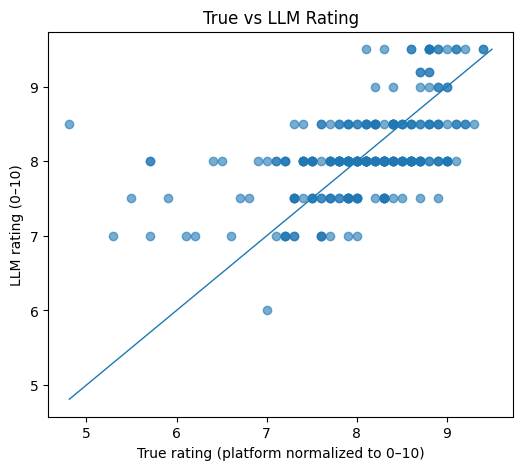

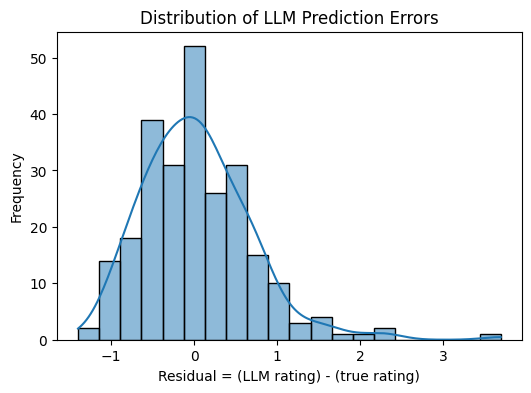

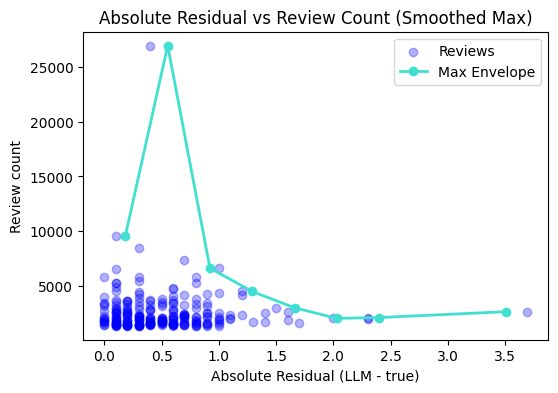

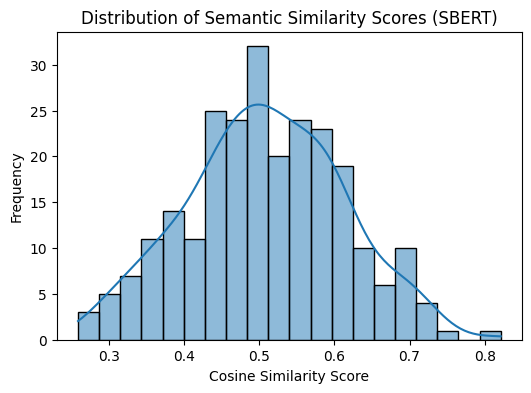

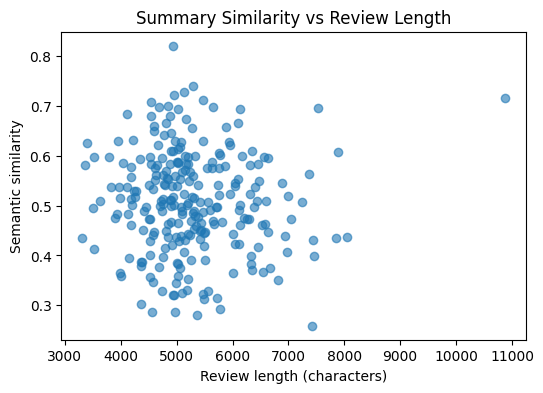

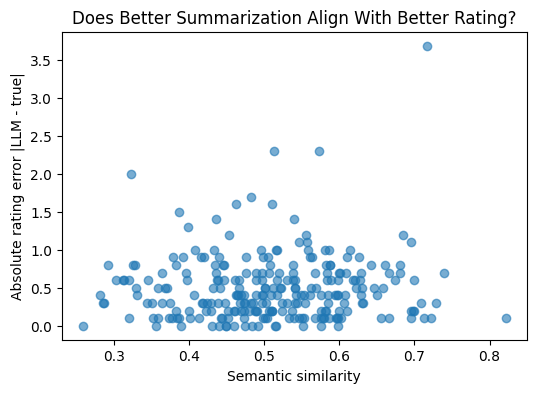

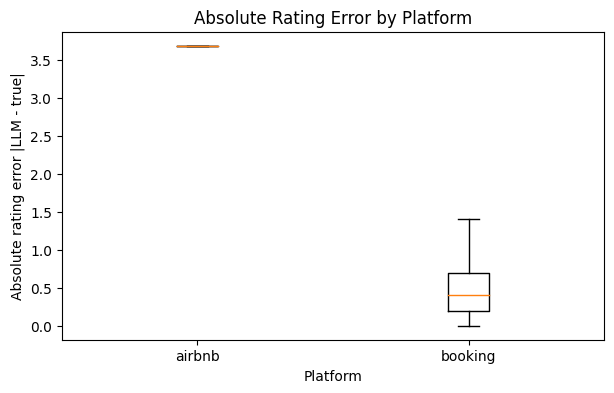

Sample size used for plots: 250
Mean semantic similarity: 0.5085523724555969
Mean abs rating error: 0.5003599999999999
SBERT input truncation chars: 3500


In [0]:
import seaborn as sns
# ----------------------------
# (1) True vs Predicted rating scatter (+ y=x)
# ----------------------------
plt.figure(figsize=(6, 5))
plt.scatter(pdf["rating_before_0_10"], pdf["llm_rating_out"], alpha=0.6)
mn = float(np.nanmin([pdf["rating_before_0_10"].min(), pdf["llm_rating_out"].min()]))
mx = float(np.nanmax([pdf["rating_before_0_10"].max(), pdf["llm_rating_out"].max()]))
plt.plot([mn, mx], [mn, mx], linewidth=1.0)
plt.xlabel("True rating (platform normalized to 0–10)")
plt.ylabel("LLM rating (0–10)")
plt.title("True vs LLM Rating")
plt.show()

# ----------------------------
# (2) Residual histogram + trace line along histogram
# ----------------------------
plt.figure(figsize=(6, 4))
# Seaborn handles the histogram and the line trace automatically
sns.histplot(pdf["residual"].dropna(), bins=20, kde=True)
plt.xlabel("Residual = (LLM rating) - (true rating)")
plt.ylabel("Frequency")
plt.title("Distribution of LLM Prediction Errors")
plt.show()

# ----------------------------
# (3) Residual vs review_count
# ----------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 4))
x = abs(pdf["residual"])
y = np.maximum(pdf["review_count_num"].values, 1.0)
temp_df = pd.DataFrame({'x': x, 'y': y}).dropna()
temp_df['bin'] = pd.cut(temp_df['x'], bins=10)
max_curve = temp_df.groupby('bin', observed=True)['y'].max()
bin_centers = [interval.mid for interval in max_curve.index]
plt.scatter(temp_df['x'], temp_df['y'], alpha=0.3, color='blue', label="Reviews")
plt.plot(bin_centers, max_curve.values, color='turquoise', linewidth=2, marker='o', label="Max Envelope")
plt.ylabel("Review count")
plt.xlabel("Absolute Residual (LLM - true)")
plt.title("Absolute Residual vs Review Count (Smoothed Max)")
plt.legend()
plt.show()

# ----------------------------
# (4) Semantic similarity distribution
# ----------------------------
plt.figure(figsize=(6, 4))
# Seaborn handles the histogram and the line trace automatically
sns.histplot(pdf["semantic_similarity"].dropna(), bins=20, kde=True)
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Semantic Similarity Scores (SBERT)")
plt.show()

# ----------------------------
# (5) Similarity vs review length
# ----------------------------
plt.figure(figsize=(6, 4))
plt.scatter(pdf["review_length"], pdf["semantic_similarity"], alpha=0.6)
plt.xlabel("Review length (characters)")
plt.ylabel("Semantic similarity")
plt.title("Summary Similarity vs Review Length")
plt.show()

# ----------------------------
# (6) Similarity vs absolute rating error
# ----------------------------
plt.figure(figsize=(6, 4))
plt.scatter(pdf["semantic_similarity"], pdf["abs_err"], alpha=0.6)
plt.xlabel("Semantic similarity")
plt.ylabel("Absolute rating error |LLM - true|")
plt.title("Does Better Summarization Align With Better Rating?")
plt.show()

# ----------------------------
# (7) Boxplot: abs error by platform
# ----------------------------
plt.figure(figsize=(7, 4))
platforms = sorted(pdf["platform_name"].dropna().unique().tolist())
data = [pdf.loc[pdf["platform_name"] == p, "abs_err"].dropna().values for p in platforms]
plt.boxplot(data, labels=platforms, showfliers=False)
plt.xlabel("Platform")
plt.ylabel("Absolute rating error |LLM - true|")
plt.title("Absolute Rating Error by Platform")
plt.show()

print("Sample size used for plots:", len(pdf))
print("Mean semantic similarity:", float(np.mean(pdf["semantic_similarity"])))
print("Mean abs rating error:", float(np.mean(pdf["abs_err"])))
print("SBERT input truncation chars:", MAX_REVIEW_CHARS_FOR_SBERT)


# Creating Baseline analysis and BERT Sentiment analyasis layer

In [0]:
# ============================================================
# FULL SELF-CONTAINED CELL:
# 1) Loads your working table into df_bert2 (auto-detects best candidate)
# 2) Runs re-AI baseline on LLM sample rows
# 3) Merges filled rows back into df_bert2
# 4) Prints sanity checks + shows examples
# ============================================================

import re
from collections import Counter
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# ============================================================
# (0) LOAD df_bert2 (auto-detect a good table)
#   - We prefer a table that contains llm_rating_0_10 and review_text_for_ai
#   - If you already have df_bert2 in memory, this will NOT overwrite it
# ============================================================

if "df_bert2" not in globals():
    # Search for a reasonable table in default.*
    tables = spark.sql("SHOW TABLES IN default").select("tableName").collect()
    candidates = [r["tableName"] for r in tables]

    chosen = None
    for t in candidates:
        try:
            tmp = spark.table(f"default.{t}")
            cols = set(tmp.columns)
            if ("review_text_for_ai" in cols) and ("llm_rating_0_10" in cols):
                chosen = f"default.{t}"
                break
        except Exception:
            pass

    if chosen is None:
        raise ValueError(
            "Could not auto-detect df_bert2 table. "
            "Set manually: df_bert2 = spark.table('default.<your_table>')"
        )

    df_bert2 = spark.table(chosen)
    print("Loaded df_bert2 from:", chosen)

print("df_bert2 columns:", len(df_bert2.columns))
print("df_bert2 rows:", df_bert2.count())

Loaded df_bert2 from: default.gold_rome_listings_baseline_and_bert
df_bert2 columns: 35
df_bert2 rows: 18690


In [0]:
# ============================================================
# ONE SELF-CONTAINED CELL (ROBUST)
# - Runs BERT on ALL rows
# - Renames re-ai -> BASELINE
# - Does NOT rely on probabilities (works even if probs are STRING)
# - Saves NEW Delta table
# ============================================================

from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, BertForSequenceClassification

# -------------------------
# CONFIG
# -------------------------
IN_TABLE  = "default.gold_rome_listings_with_llm_or_reai_cards_ordered"
OUT_TABLE = "default.gold_rome_listings_BASELINE_and_BERT"

TEXT_COL = "review_text_for_ai"
BERT_MODEL = "finetunedmodel_hotel_sentiment_5k"
LANG = "en"

# Mapping assumption for this model (can flip after quick inspection)
POS_LABEL = "LABEL_0"
NEG_LABEL = "LABEL_1"

# -------------------------
# 1) Load
# -------------------------
df = spark.table(IN_TABLE)
print("Loaded:", IN_TABLE, "| rows:", df.count())

if TEXT_COL not in df.columns:
    raise ValueError(f"Missing {TEXT_COL} in input table")

# -------------------------
# 2) Rename re-ai -> BASELINE
# -------------------------
rename_map = {
    "re_summary": "baseline_summary",
    "re_pros": "baseline_pros",
    "re_cons": "baseline_cons",
    "re_rating_0_10": "baseline_rating_0_10",
}
for old, new in rename_map.items():
    if old in df.columns:
        df = df.withColumnRenamed(old, new)
print("Renamed re-AI -> BASELINE")

# -------------------------
# 3) Prepare BERT input
# -------------------------
df = df.withColumn(
    "text_for_bert",
    F.when(F.col(TEXT_COL).isNull(), F.lit(""))
     .otherwise(F.substring(F.col(TEXT_COL).cast("string"), 1, 2000))
)

df = df.cache()
_ = df.count()

# -------------------------
# 4) Spark NLP pipeline (avoid 'class' ambiguity)
# -------------------------
document = DocumentAssembler().setInputCol("text_for_bert").setOutputCol("document")
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
clf = (BertForSequenceClassification
       .pretrained(BERT_MODEL, LANG)
       .setInputCols(["document", "token"])
       .setOutputCol("bert_class"))

pipeline = Pipeline(stages=[document, tokenizer, clf])

dummy = spark.createDataFrame([("ok",)], ["text_for_bert"])
bert_model = pipeline.fit(dummy)

print("BERT pipeline ready — running inference...")

df2 = bert_model.transform(df)

# -------------------------
# 5) Extract label only (robust)
# -------------------------
df2 = df2.withColumn("bert_label", F.col("bert_class.result")[0])

df2 = df2.withColumn(
    "bert_sentiment",
    F.when(F.col("bert_label") == POS_LABEL, F.lit("positive"))
     .when(F.col("bert_label") == NEG_LABEL, F.lit("negative"))
     .otherwise(F.lit(None))
)

# Label-based numeric mapping (simple baseline)
df2 = df2.withColumn(
    "bert_rating_0_10",
    F.when(F.col("bert_sentiment") == "positive", F.lit(8.0))
     .when(F.col("bert_sentiment") == "negative", F.lit(3.0))
     .otherwise(F.lit(None).cast("double"))
)

# -------------------------
# 6) Drop NLP columns
# -------------------------
df2 = df2.drop("text_for_bert", "document", "token", "bert_class")

print("BERT inference complete.")

# -------------------------
# 7) Save
# -------------------------
df2.write.mode("overwrite").format("delta").saveAsTable(OUT_TABLE)
print("Saved:", OUT_TABLE)

# -------------------------
# 8) Sanity checks
# -------------------------
df2.groupBy("bert_label").count().show(50, truncate=False)
df2.groupBy("bert_sentiment").count().show(50, truncate=False)

df2.select(
    "listing_id",
    "baseline_rating_0_10",
    "bert_label",
    "bert_sentiment",
    "bert_rating_0_10"
).show(10, truncate=False)


Loaded: default.gold_rome_listings_with_llm_or_reai_cards_ordered | rows: 18690
Renamed re-AI -> BASELINE
finetunedmodel_hotel_sentiment_5k download started this may take some time.
Approximate size to download 40.2 MB
[OK!]
🏃 View run luminous-jay-166 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/2596082603232248/runs/f734a6704fe6459fa6fac3ca0fe319cf
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/2596082603232248
BERT pipeline ready — running inference...
BERT inference complete.
Saved: default.gold_rome_listings_BASELINE_and_BERT
+----------+-----+
|bert_label|count|
+----------+-----+
|LABEL_1   |6550 |
|LABEL_0   |12140|
+----------+-----+

+--------------+-----+
|bert_sentiment|count|
+--------------+-----+
|positive      |12140|
|negative      |6550 |
+--------------+-----+

+-------------------+--------------------+----------+--------------+----------------+
|listing_id         |baseline_rating_0_10|bert_label|bert

# Save results

In [0]:
# ============================================================
# EXPORT FINAL DATASET
# - Full CSV
# - 50-row sample CSV
# ============================================================

from pyspark.sql import functions as F

FINAL_TABLE = "default.gold_rome_listings_BASELINE_and_BERT"

df = spark.table(FINAL_TABLE)
print("Loaded:", FINAL_TABLE)
print("Rows:", df.count())

# ------------------------------------------------------------
# Columns to export (edit if needed)
# ------------------------------------------------------------
export_cols = [
    "platform",
    "platform_name",
    "listing_id",
    "title_norm",
    "source_url",
    "review_count",
    "rating",
    "bert_sentiment",
    "bert_rating_0_10",

    "final_ai_method",
    "final_ai_rating_0_10",

    "review_text_for_ai",
]

export_cols = [c for c in export_cols if c in df.columns]
export_df = df.select(*export_cols)
export_df = export_df.withColumnRenamed("final_ai_rating_0_10","baseline_rating_0_10")

# ------------------------------------------------------------
# Helper: write single CSV
# ------------------------------------------------------------
def write_single_csv(df, out_name):
    tmp_dir = f"dbfs:/tmp/{out_name}_tmp"
    final_dir = "dbfs:/FileStore/exports"

    dbutils.fs.rm(tmp_dir, True)
    (
        df.repartition(1)
          .write
          .mode("overwrite")
          .option("header", True)
          .option("quoteAll", True)
          .csv(tmp_dir)
    )

    part = [f.path for f in dbutils.fs.ls(tmp_dir) if f.name.startswith("part-")][0]
    final_path = f"{final_dir}/{out_name}.csv"
    dbutils.fs.cp(part, final_path)
    return final_path

# ------------------------------------------------------------
# 1) FULL DATASET EXPORT
# ------------------------------------------------------------
full_path = write_single_csv(export_df, "rome_hotels_FINAL_full")
print("Full CSV:")
print("/files/exports/rome_hotels_FINAL_full.csv")

# ------------------------------------------------------------
# 2) 50-ROW SAMPLE EXPORT
# (deterministic: highest review_count)
# ------------------------------------------------------------
sample_50 = export_df.orderBy(F.desc(F.col("review_count"))).limit(50)

sample_path = write_single_csv(sample_50, "rome_hotels_FINAL_sample_50")
print("50-row sample CSV:")
print("/files/exports/rome_hotels_FINAL_sample_50.csv")

print("Done.")


Loaded: default.gold_rome_listings_BASELINE_and_BERT
Rows: 18690
Full CSV:
/files/exports/rome_hotels_FINAL_full.csv
50-row sample CSV:
/files/exports/rome_hotels_FINAL_sample_50.csv
Done.


# Download table for interface

In [0]:
# filter for llm not null values
df = spark.table("default.gold_rome_listings_BASELINE_and_BERT").filter("llm_summary is not null")
# Write table for interface
df.write.mode("overwrite").format("delta").saveAsTable("default.rome_llm_summaries_interface")
export_cols = [
    "listing_id",
    "title_norm",
    "source_url",
    "review_count",
    "rating",
    "llm_summary",
    "llm_pros",
    "llm_cons",
    "llm_rating_0_10",
    "llm_card"
]

export_cols = [c for c in export_cols if c in df.columns]
export_df = df.select(*export_cols)
write_single_csv(export_df, "rome_llm_summaries_interface")

'dbfs:/FileStore/exports/rome_llm_summaries_interface.csv'